In [37]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from datetime import date
import geopandas as gpd
import geoplot
import warnings
warnings.filterwarnings('ignore') 

# KBQ 3
How does the distribution of education services align with AEDC outcomes across LGAs? Specifically, do areas with higher proportions of developmentally vulnerable children (DV1 or DV2) also have fewer high-quality education services?

Data Preparation

In [39]:
data = pd.read_csv('Education-services-au-export.csv')

In [41]:
data['Postcode'] = data['Postcode'].dropna().astype(int).astype(str)

In [43]:
data['Region'] = data['Suburb'].str.upper().str.strip() + ", " + data['State']

data['Exceeding_NQS'] = data['OverallRating'].str.lower() == 'exceeding nqs'

region_summary = data.groupby('Region').agg({
    'ServiceName': 'count',
    'Exceeding_NQS': 'mean',   
    'NumberOfApprovedPlaces': 'mean'  
}).rename(columns={
    'ServiceName': 'Num_Services',
    'Exceeding_NQS': 'Pct_Exceeding_NQS',
    'NumberOfApprovedPlaces': 'Avg_Approved_Places'
}).reset_index()


In [45]:
lga_file = 'LGA 2009-21.xlsx'
dv1_data = pd.read_excel(lga_file, sheet_name='LGA One or more', skiprows=6)
dv2_data = pd.read_excel(lga_file, sheet_name='LGA Two or more', skiprows=6)
lang_data = pd.read_excel(lga_file, sheet_name='LGA Language', skiprows=6)

# Rename
dv1_clean = dv1_data[['Unnamed: 2', dv1_data.columns[-1]]].rename(
    columns={'Unnamed: 2': 'LGA Name', dv1_data.columns[-1]: 'DV1_%'}
)
dv2_clean = dv2_data[['Unnamed: 2', dv2_data.columns[-1]]].rename(
    columns={'Unnamed: 2': 'LGA Name', dv2_data.columns[-1]: 'DV2_%'}
)
lang_clean = lang_data[['Unnamed: 2', lang_data.columns[-1]]].rename(
    columns={'Unnamed: 2': 'LGA Name', lang_data.columns[-1]: 'Language_%'}
)

# merge
aedc_summary = dv1_clean.merge(dv2_clean, on='LGA Name').merge(lang_clean, on='LGA Name')
aedc_summary = aedc_summary.dropna(subset=['LGA Name', 'DV1_%', 'DV2_%', 'Language_%']).reset_index(drop=True)

print(aedc_summary.head())


            LGA Name      DV1_%      DV2_% Language_%
0             Albury  24.345146  13.734568   6.317411
1  Armidale Regional  27.687296  13.680782   10.09772
2            Ballina  16.915423   8.955224   6.716418
3          Balranald  47.058824  29.411765  11.764706
4  Bathurst Regional  31.683168  15.984405   6.420233


In [47]:
data = pd.read_csv('Education-services-au-export.csv')  

data["Postcode"] = data["Postcode"].astype(str).str.extract(r'(\d+)')

In [49]:
data["Postcode"] = (
    data["Postcode"].astype(str).str.extract(r"(\\d+)", expand=False)
)

In [51]:
gdf = gpd.read_file('LGA_2021_AUST_GDA2020.shp')

gdf.to_file('LGA_2021_AUST_GDA2020.geojson', driver='GeoJSON')

In [53]:
pio.renderers.default = 'jupyterlab'

aus = gpd.read_file('LGA_2021_AUST_GDA2020.dbf')
aus.geometry = aus.geometry.simplify(0.001)
shapefile_path = "LGA_2021_AUST_GDA2020.shp"
choropleth_data_path = "lgageo_lga.csv"

gdf = gpd.read_file(shapefile_path)
df_lga = pd.read_csv(choropleth_data_path)
# === standardize code ===
gdf["lgacode"] = gdf["LGA_CODE21"].astype(str)
df_lga["lgacode"] = df_lga["lgacode"].astype(str)
aus['LGA_CODE21'] = aus['LGA_CODE21'].astype(str)
# === merge ===
# Merge the GeoDataFrame with the servoce DataFrame based on region code, keeping all entries from mortgage.
merged_geo = aus.merge(df_lga, how='left',left_on = 'LGA_CODE21', right_on = 'lgacode')
# drop geometry == null
merged_geo = merged_geo[merged_geo["geometry"].notnull()]
# drop unuseful
merged_geo.drop(columns=["Unnamed: 0", "lgacode", "Name"], inplace=True)

# fillna with institution_count = 0
merged_geo["institution_count"] = merged_geo["institution_count"].fillna(0)
merged_geo.isnull().sum()

LGA_CODE21                          0
LGA_NAME21                          0
STE_CODE21                          0
STE_NAME21                          0
AUS_CODE21                          0
AUS_NAME21                          0
AREASQKM21                          0
LOCI_URI21                          0
SHAPE_Leng                          0
SHAPE_Area                          0
geometry                            0
institution_count                   0
median_drive_time                 130
Developmentally vulnerable (%)    130
dtype: int64

In [61]:
lgageo_ser_lga = pd.read_csv('lgageo_ser_lga.csv')
geojson = merged_geo.__geo_interface__
lga_service_count = lgageo_ser_lga.groupby('lgacode').size().reset_index(name='service_count')
fig = px.choropleth(
    lga_service_count,
    geojson=geojson,
    locations="lgacode",         
    color="service_count",
    color_continuous_scale="Oranges",
    featureidkey="properties.LGA_CODE21",  
    title="Geographic Distribution of Education Services by LGA",
)

fig.update_geos(
    projection_type="natural earth",
    fitbounds="locations",
    showcountries=True,
    showcoastlines=True,
    showland=True,
    landcolor="rgb(240, 240, 240)",
    oceancolor="rgb(230, 240, 255)",
    showocean=True
)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.write_html("education_services_by_lga.html")

The above interactive map can be found in an independent file.

In [57]:
dv1_df = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA One or more")
# Clean DV1 data
dv1_cleaned = dv1_df.iloc[6:, [2, 17]].copy()
dv1_cleaned.columns = ["LGA_name", "DV1_Percentage"]
dv1_cleaned = dv1_cleaned.dropna().reset_index(drop=True)
dv1_cleaned["DV1_Percentage"] = pd.to_numeric(dv1_cleaned["DV1_Percentage"], errors="coerce")

dv2_df = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA Two or more")
# Clean DV2 data
dv2_cleaned = dv2_df.iloc[6:, [2, 17]].copy()
dv2_cleaned.columns = ["LGA_name", "DV2_Percentage"]
dv2_cleaned = dv2_cleaned.dropna().reset_index(drop=True)
dv2_cleaned["DV2_Percentage"] = pd.to_numeric(dv2_cleaned["DV2_Percentage"], errors="coerce")

# Merge DV1 and DV2 data
aedc_data = pd.merge(dv1_cleaned, dv2_cleaned, on="LGA_name")

# Load education services data and postcode-to-LGA mapping
edu_df = pd.read_csv("Education-services-au-export.csv", low_memory=False)
postcode_lga = pd.read_csv("australian_postcodes.csv")

# Extract numeric postcode from education data and convert type
edu_df = edu_df.dropna(subset=["Postcode", "OverallRating"])
edu_df["Postcode"] = edu_df["Postcode"].astype(str).str.extract(r"(\d+)").astype(float)

# Merge with postcode-to-LGA mapping
postcode_lga = postcode_lga[["postcode", "lgaregion"]].dropna().drop_duplicates()
postcode_lga.columns = ["Postcode", "LGA_name"]
edu_lga = edu_df.merge(postcode_lga, on="Postcode", how="left")

# Calculate high-quality education services per LGA
edu_lga["HighQuality"] = (edu_lga["OverallRating"] == "Exceeding NQS").astype(int)
hq_counts = edu_lga.groupby("LGA_name")["HighQuality"].sum().reset_index(name="Exceeding_NQS_Count")

# Merge with AEDC DV data
aedc_merged = aedc_data.merge(hq_counts, on="LGA_name", how="left")
aedc_merged["Exceeding_NQS_Count"] = aedc_merged["Exceeding_NQS_Count"].fillna(0)

# Analyze correlations
correlation = aedc_merged[["DV1_Percentage", "DV2_Percentage", "Exceeding_NQS_Count"]].corr()
print("Correlation between DV1/DV2 and number of Exceeding NQS services:")
print(correlation)


Correlation between DV1/DV2 and number of Exceeding NQS services:
                     DV1_Percentage  DV2_Percentage  Exceeding_NQS_Count
DV1_Percentage             1.000000        0.934118            -0.171600
DV2_Percentage             0.934118        1.000000            -0.165583
Exceeding_NQS_Count       -0.171600       -0.165583             1.000000


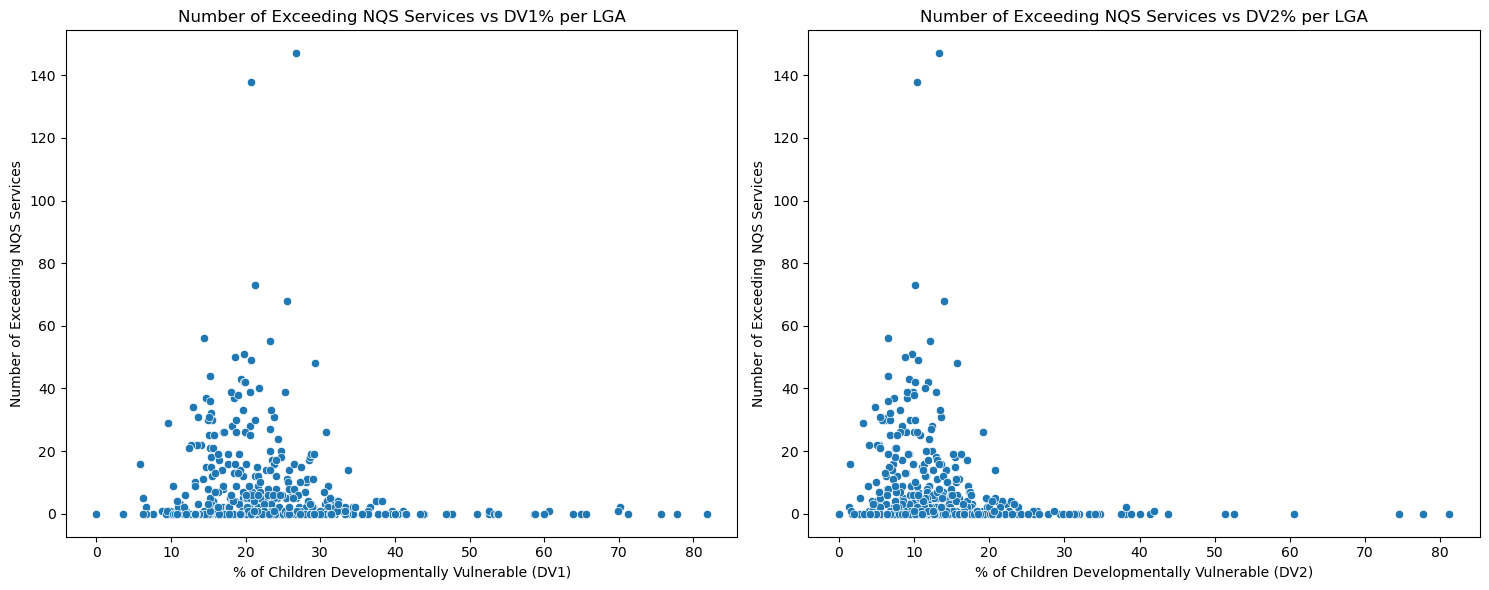

In [59]:
# Visualization with swapped axes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=aedc_merged, y="Exceeding_NQS_Count", x="DV1_Percentage", ax=axes[0])
axes[0].set_title("Number of Exceeding NQS Services vs DV1% per LGA")
axes[0].set_ylabel("Number of Exceeding NQS Services")
axes[0].set_xlabel("% of Children Developmentally Vulnerable (DV1)")

sns.scatterplot(data=aedc_merged, y="Exceeding_NQS_Count", x="DV2_Percentage", ax=axes[1])
axes[1].set_title("Number of Exceeding NQS Services vs DV2% per LGA")
axes[1].set_ylabel("Number of Exceeding NQS Services")
axes[1].set_xlabel("% of Children Developmentally Vulnerable (DV2)")

plt.tight_layout()
plt.show()

# KBQ 4
Do LGAs with a higher percentage of education services rated as "Exceeding National Quality Standards" (NQS) show better AEDC outcomes, particularly in domains such as language and cognitive skills? What is the relationship between operational capacity (e.g., the number of children served) and developmental vulnerability indicators? What is the relationship between enrolment rates, attendance rates and developmental vulnerability indicators?


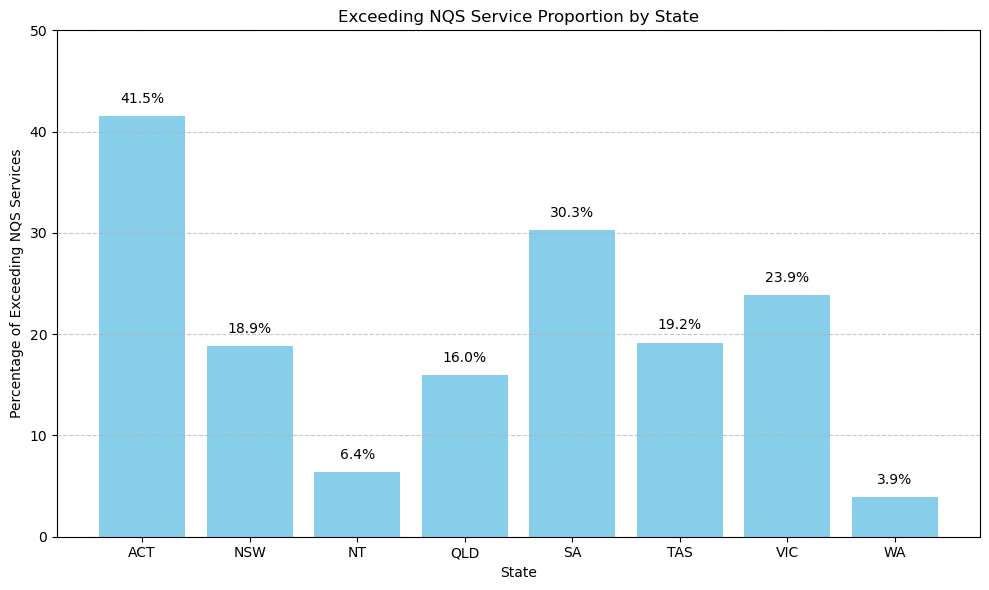

In [64]:
state_rating_summary = data.groupby("State").agg(
    Total_Services=("ServiceApprovalNumber", "count"),
    Exceeding_Services=("OverallRating", lambda x: (x == "Exceeding NQS").sum())
).reset_index()

# %
state_rating_summary["Pct_Exceeding_NQS"] = (
    state_rating_summary["Exceeding_Services"] / state_rating_summary["Total_Services"] * 100
)

# Draw figure
plt.figure(figsize=(10, 6))
bars = plt.bar(state_rating_summary["State"], state_rating_summary["Pct_Exceeding_NQS"], color="skyblue")
plt.xlabel("State")
plt.ylabel("Percentage of Exceeding NQS Services")
plt.title("Exceeding NQS Service Proportion by State")
plt.ylim(0, 50)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# label
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [66]:
dv1_df = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA One or more")
dv2_df = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA Two or more")
language_df = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA Language")

In [68]:
edu_df = pd.read_csv("Education-services-au-export.csv", low_memory=False)
postcode_lga = pd.read_csv("CG_POSTCODE_2024_LGA_2024.csv")

In [70]:
edu_df = pd.read_csv("Education-services-au-export.csv", low_memory=False)
postcode_lga = pd.read_csv("CG_POSTCODE_2024_LGA_2024.csv")

edu_df = edu_df.dropna(subset=["Postcode"])
edu_df["Postcode"] = edu_df["Postcode"].astype(str).str.extract(r"(\d{4})")[0]
edu_df = edu_df.dropna(subset=["Postcode"])
edu_df["Postcode"] = edu_df["Postcode"].astype(int)

postcode_lga = postcode_lga.rename(columns={"POSTCODE": "Postcode", "LGA_NAME_2024": "LGA_name"})
postcode_lga = postcode_lga.dropna(subset=["Postcode", "LGA_name"])
postcode_lga["Postcode"] = postcode_lga["Postcode"].astype(int)

edu_lga = edu_df.merge(postcode_lga[["Postcode", "LGA_name"]], on="Postcode", how="left")

print(edu_lga[["ServiceName", "Postcode", "LGA_name"]].head())

                                         ServiceName  Postcode    LGA_name
0    Community Kids Waterford Early Education Centre      4133       Logan
1                  KIDVENTURE EARLY LEARNING EAGLEBY      4207  Gold Coast
2                  KIDVENTURE EARLY LEARNING EAGLEBY      4207       Logan
3                 Community Kids - Broadbeach Waters      4217  Gold Coast
4  Little Scholars School of Early Learning Burle...      4220  Gold Coast


In [72]:
edu_df = pd.read_csv("Education-services-au-export.csv", low_memory=False)

edu_df = edu_df.dropna(subset=["Postcode", "OverallRating"])

edu_df["Postcode"] = edu_df["Postcode"].astype(str).str.extract(r"(\d{4})")[0]

#Asked GPT how to ignore Nan
edu_df = edu_df[edu_df["Postcode"].notnull()]

edu_df["Postcode"] = edu_df["Postcode"].astype(int)

print(edu_df["Postcode"].head())
print(edu_df["Postcode"].dtype)

0    4133
1    4207
2    4217
3    4220
4    4211
Name: Postcode, dtype: int32
int32



Correlation between %Exceeding NQS and Language & Cognitive Vulnerability:
                  LangCog_Vuln  Pct_ExceedingNQS
LangCog_Vuln          1.000000          0.173037
Pct_ExceedingNQS      0.173037          1.000000


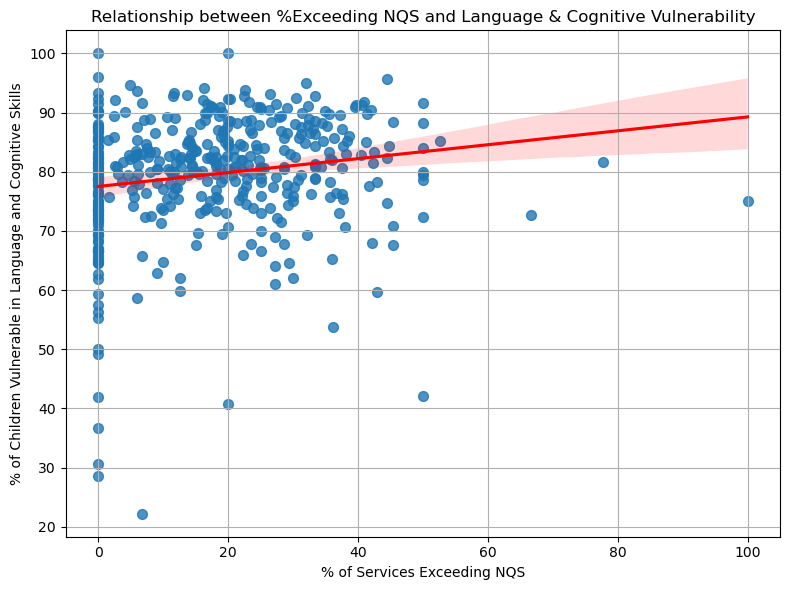

In [74]:
postcode_lga = pd.read_csv("CG_POSTCODE_2024_LGA_2024.csv")
postcode_lga = postcode_lga.rename(columns={"POSTCODE": "Postcode", "LGA_NAME_2024": "LGA_name"})

postcode_lga = postcode_lga.dropna(subset=["Postcode", "LGA_name"])
postcode_lga["Postcode"] = pd.to_numeric(postcode_lga["Postcode"], errors="coerce")
postcode_lga = postcode_lga.dropna(subset=["Postcode"])

postcode_lga["Postcode"] = postcode_lga["Postcode"].astype(int)

language_df = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA Language")
language_cleaned = language_df.iloc[6:, [2, 17]].copy()
language_cleaned.columns = ["LGA_name", "LangCog_Vuln"]
language_cleaned = language_cleaned.dropna().reset_index(drop=True)
language_cleaned["LangCog_Vuln"] = pd.to_numeric(language_cleaned["LangCog_Vuln"], errors="coerce")


edu_df = pd.read_csv("Education-services-au-export.csv", low_memory=False)

edu_df = edu_df.dropna(subset=["Postcode", "OverallRating"])

edu_df["Postcode"] = edu_df["Postcode"].astype(str).str.extract(r"(\d{4})")[0]
edu_df = edu_df.dropna(subset=["Postcode"])
edu_df["Postcode"] = edu_df["Postcode"].astype(int)

postcode_lga = postcode_lga.rename(columns={"POSTCODE": "Postcode", "LGA_NAME_2024": "LGA_name"})
postcode_lga["Postcode"] = postcode_lga["Postcode"].astype(int)
edu_lga = edu_df.merge(postcode_lga[["Postcode", "LGA_name"]], on="Postcode", how="left")

edu_lga["HighQuality"] = (edu_lga["OverallRating"] == "Exceeding NQS").astype(int)
agg = edu_lga.groupby("LGA_name").agg(
    Total=("HighQuality", "count"),
    HighQualityCount=("HighQuality", "sum")
).reset_index()
agg["Pct_ExceedingNQS"] = (agg["HighQualityCount"] / agg["Total"]) * 100

merged = language_cleaned.merge(agg, on="LGA_name", how="left").dropna(subset=["Pct_ExceedingNQS"])

corr = merged[["LangCog_Vuln", "Pct_ExceedingNQS"]].corr()
print("\nCorrelation between %Exceeding NQS and Language & Cognitive Vulnerability:")
print(corr)

plt.figure(figsize=(8, 6))
sns.regplot(data=merged, x="Pct_ExceedingNQS", y="LangCog_Vuln", scatter_kws={"s": 50}, line_kws={"color": "red"})
plt.title("Relationship between %Exceeding NQS and Language & Cognitive Vulnerability")
plt.xlabel("% of Services Exceeding NQS")
plt.ylabel("% of Children Vulnerable in Language and Cognitive Skills")
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
education_data = pd.read_csv("Education-services-au-export.csv")
postcode_lga_mapping = pd.read_csv("CG_POSTCODE_2024_LGA_2024.csv")

education_data['Postcode'] = pd.to_numeric(education_data['Postcode'], errors='coerce')
postcode_lga_mapping['POSTCODE'] = pd.to_numeric(postcode_lga_mapping['POSTCODE'], errors='coerce')

merged_data = pd.merge(education_data, postcode_lga_mapping, left_on='Postcode', right_on='POSTCODE', how='left')

lga_aggregated = merged_data.groupby('LGA_NAME_2024').agg(
    Total_Approved_Places=('NumberOfApprovedPlaces', 'sum'),
    Number_of_Services=('ServiceApprovalNumber', 'count')
).reset_index()

dv1_clean = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA One or more", skiprows=4)
dv2_clean = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA Two or more", skiprows=4)

dv1_selected = dv1_clean[['Name', 'Unnamed: 16']].rename(
    columns={'Name': 'LGA_NAME_2024', 'Unnamed: 16': 'DV1_2021_pct'}
).dropna()

dv2_selected = dv2_clean[['Name', 'Unnamed: 16']].rename(
    columns={'Name': 'LGA_NAME_2024', 'Unnamed: 16': 'DV2_2021_pct'}
).dropna()

dv_combined = pd.merge(dv1_selected, dv2_selected, on='LGA_NAME_2024', how='outer')

full_merged = pd.merge(lga_aggregated, dv_combined, on='LGA_NAME_2024', how='left')
full_merged['DV1_2021_pct'] = pd.to_numeric(full_merged['DV1_2021_pct'], errors='coerce')
full_merged['DV2_2021_pct'] = pd.to_numeric(full_merged['DV2_2021_pct'], errors='coerce')

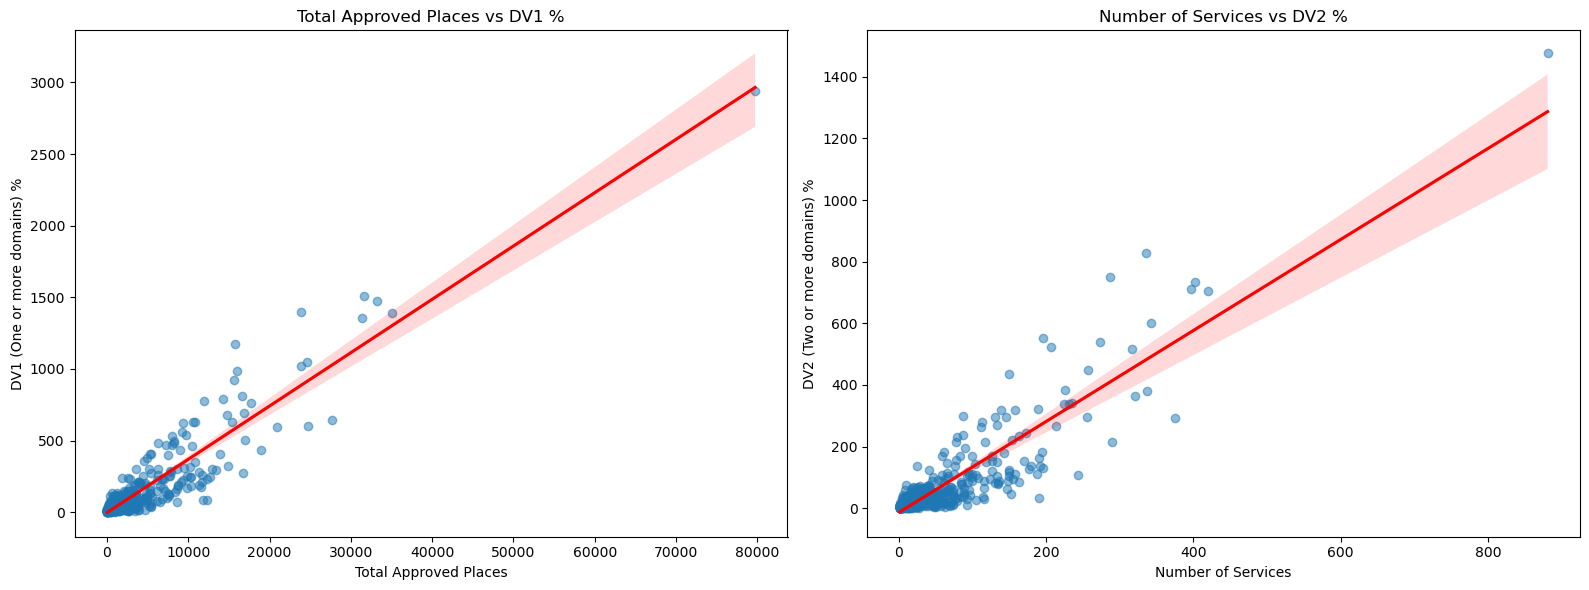

In [78]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.regplot(
    data=full_merged,
    x='Total_Approved_Places',
    y='DV1_2021_pct',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title('Total Approved Places vs DV1 %')
plt.xlabel('Total Approved Places')
plt.ylabel('DV1 (One or more domains) %')

plt.subplot(1, 2, 2)
sns.regplot(
    data=full_merged,
    x='Number_of_Services',
    y='DV2_2021_pct',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title('Number of Services vs DV2 %')
plt.xlabel('Number of Services')
plt.ylabel('DV2 (Two or more domains) %')

plt.tight_layout()
plt.show()

In [80]:
enrolment_df = pd.read_excel("42400DO002_2023.xlsx", sheet_name="Table_2", skiprows=4)
attendance_df = pd.read_excel("42400DO002_2023.xlsx", sheet_name="Table_3", skiprows=4)

enrolment_totals = enrolment_df.loc[[2, 4], ['NSW', 'Vic.', 'Qld', 'SA', 'WA', 'Tas.', 'NT', 'ACT', 'Aust.']].sum()
attendance_totals = attendance_df.loc[[2, 4], ['NSW', 'Vic.', 'Qld', 'SA', 'WA', 'Tas.', 'NT', 'ACT', 'Aust.']].sum()

state_data = pd.DataFrame({
    'State': enrolment_totals.index,
    'Enrolment': enrolment_totals.values,
    'Attendance': attendance_totals.values
})
state_data['Attendance_Rate'] = state_data['Attendance'] / state_data['Enrolment']

education_data = pd.read_csv("Education-services-au-export.csv")
postcode_lga_mapping = pd.read_csv("CG_POSTCODE_2024_LGA_2024.csv")
education_data['Postcode'] = pd.to_numeric(education_data['Postcode'], errors='coerce')
postcode_lga_mapping['POSTCODE'] = pd.to_numeric(postcode_lga_mapping['POSTCODE'], errors='coerce')
merged_data = pd.merge(education_data, postcode_lga_mapping, left_on='Postcode', right_on='POSTCODE', how='left')

lga_aggregated = merged_data.groupby('LGA_NAME_2024').agg(
    Total_Approved_Places=('NumberOfApprovedPlaces', 'sum'),
    Number_of_Services=('ServiceApprovalNumber', 'count')
).reset_index()

dv1_clean = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA One or more", skiprows=4)
dv2_clean = pd.read_excel("LGA 2009-21.xlsx", sheet_name="LGA Two or more", skiprows=4)

dv1_selected = dv1_clean[['Name', 'Unnamed: 16']].rename(
    columns={'Name': 'LGA_NAME_2024', 'Unnamed: 16': 'DV1_2021_pct'}
).dropna()
dv2_selected = dv2_clean[['Name', 'Unnamed: 16']].rename(
    columns={'Name': 'LGA_NAME_2024', 'Unnamed: 16': 'DV2_2021_pct'}
).dropna()

dv_combined = pd.merge(dv1_selected, dv2_selected, on='LGA_NAME_2024', how='outer')
full_merged = pd.merge(lga_aggregated, dv_combined, on='LGA_NAME_2024', how='left')

full_merged['DV1_2021_pct'] = pd.to_numeric(full_merged['DV1_2021_pct'], errors='coerce')
full_merged['DV2_2021_pct'] = pd.to_numeric(full_merged['DV2_2021_pct'], errors='coerce')

education_states = merged_data[['LGA_NAME_2024', 'State']].drop_duplicates()
dv_with_states = pd.merge(full_merged, education_states, on='LGA_NAME_2024', how='left').dropna(subset=['State'])

dv_by_state = dv_with_states.groupby('State').agg({
    'DV1_2021_pct': 'mean',
    'DV2_2021_pct': 'mean'
}).reset_index()


state_combined = pd.merge(state_data, dv_by_state, on='State', how='left')

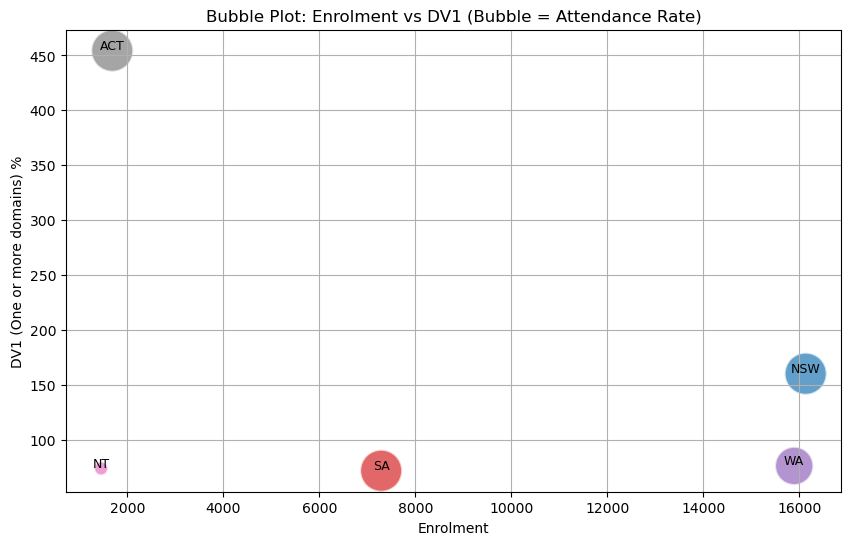

In [82]:
filtered = state_combined.dropna(subset=['Attendance_Rate', 'DV1_2021_pct', 'DV2_2021_pct'])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=state_combined,
    x='Enrolment',
    y='DV1_2021_pct',
    size='Attendance_Rate',
    hue='State',
    sizes=(100, 1000),
    legend=False,
    alpha=0.7
)
for i, row in filtered.iterrows():
    plt.text(row['Enrolment'], row['DV1_2021_pct'] + 1, row['State'], fontsize=9, ha='center')

plt.title('Bubble Plot: Enrolment vs DV1 (Bubble = Attendance Rate)')
plt.xlabel('Enrolment')
plt.ylabel('DV1 (One or more domains) %')
plt.grid(True)
plt.show()

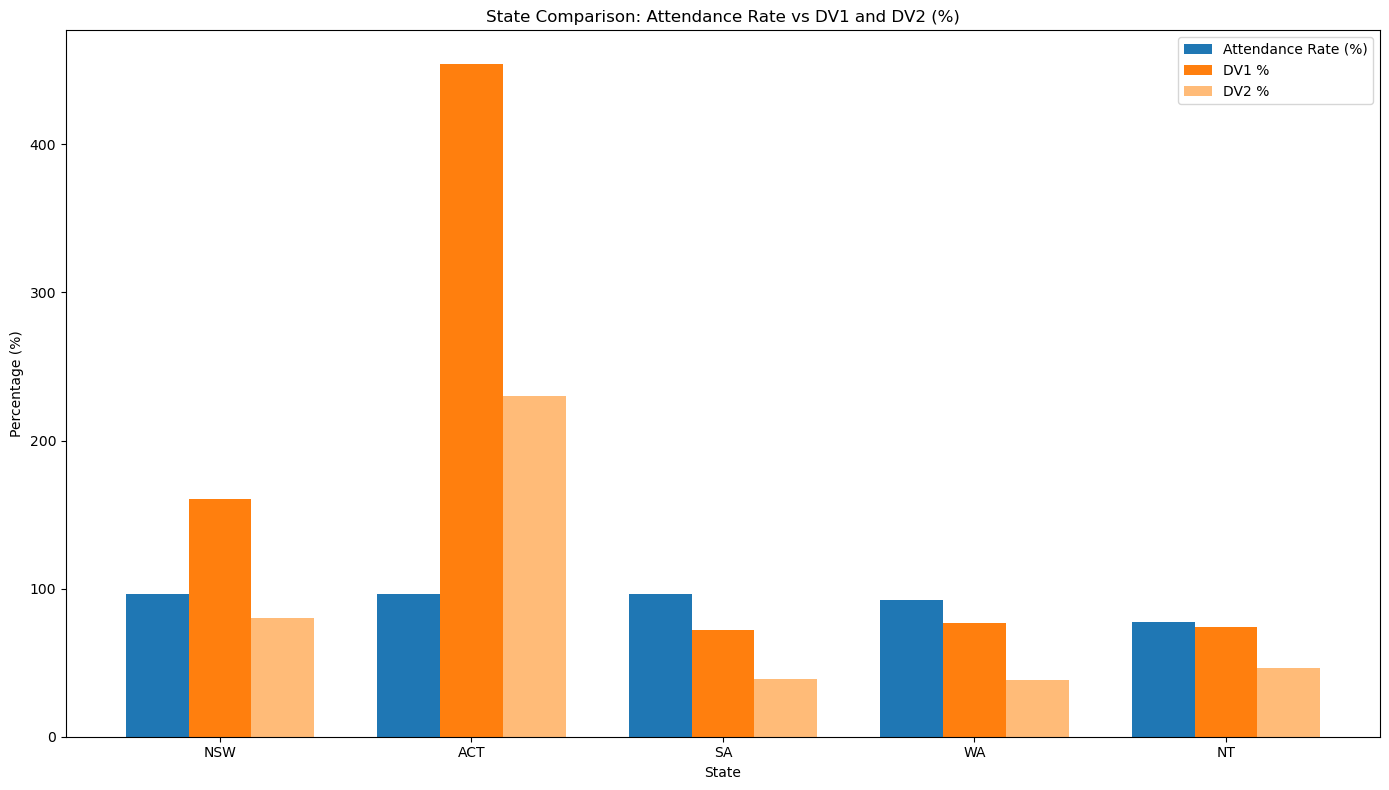

In [84]:
bar_data = filtered.sort_values(by='Attendance_Rate', ascending=False)
x = range(len(bar_data))
bar_width = 0.25
bar_data = filtered.copy()
bar_data['Attendance_Rate'] = bar_data['Attendance_Rate'] * 100
bar_data = bar_data.sort_values(by='Attendance_Rate', ascending=False)

plt.figure(figsize=(14, 8))
x = range(len(bar_data))
bar_width = 0.25

plt.bar([p for p in x], bar_data['Attendance_Rate'], width=bar_width, label='Attendance Rate (%)', color='#1f77b4')
plt.bar([p + bar_width for p in x], bar_data['DV1_2021_pct'], width=bar_width, label='DV1 %', color='#ff7f0e')
plt.bar([p + bar_width * 2 for p in x], bar_data['DV2_2021_pct'], width=bar_width, label='DV2 %', color='#ffbb78')

plt.xticks([p + bar_width for p in x], bar_data['State'])
plt.xlabel('State')
plt.ylabel('Percentage (%)')
plt.title('State Comparison: Attendance Rate vs DV1 and DV2 (%)')
plt.legend()
plt.tight_layout()
plt.show()